# Aula Prática 03 - Dinâmica Molecular em Ensemble NVE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares)

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dinâmica Molecular no Ensemble NVE 

- $N$: número de partículas
- $V$: volume 
- $E$: energia


In [ ]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

def duljdr(r,epsilon=1.0,sigma=1.0):
    return -4*epsilon*((12*(sigma/r)**12-6*(sigma/r)**6)/r)

In [ ]:
def posicoes_iniciais(Np, L):
    # array como posições das partículas
    r = np.zeros((Np,3))
    
    # Número de pontos em x e y
    Nx = Ny = Nz = int(np.ceil(np.power(Np,1/3.0)))

    # Espaçamento entre os átomos
    dx = L/Nx
    dy = L/Ny
    dz = L/Nz

    # Posições possíveis em x e y
    id = 0
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                if (id < Np):
                    r[id][0] = (i+0.5)*dx
                    r[id][1] = (j+0.5)*dy
                    r[id][2] = (k+0.5)*dz
                    id +=1
    return r

In [ ]:
def interacao_lj(r,L,epsilon=1.0,sigma=1.0,rcut=2.5):
    U = 0.0
    a = np.zeros_like(r)
    for i in range(r.shape[0]):
        for j in range(i+1,r.shape[0]):
            rij = r[i]-r[j]
            # aplicando pbc
            rij[0] -= np.rint(rij[0]/L)*L # em x
            rij[1] -= np.rint(rij[1]/L)*L # em y
            rij[2] -= np.rint(rij[2]/L)*L # em z
            # calcula distancia entre duas particulas
            rij_norm = np.linalg.norm(rij)
            if rij_norm < rcut:
                # calcula energia interna
                U += ulj(rij_norm,epsilon,sigma)
                # calcula a derivada do potencial
                dudr = duljdr(rij_norm,epsilon,sigma)
                # calcula aceleração na particula i
                a[i][0] += -dudr*rij[0]/rij_norm
                a[i][1] += -dudr*rij[1]/rij_norm
                a[i][2] += -dudr*rij[2]/rij_norm
                # calcula aceleração na particula j usando 3ª Lei de Newton
                a[j][0] += dudr*rij[0]/rij_norm
                a[j][1] += dudr*rij[1]/rij_norm
                a[j][2] += dudr*rij[2]/rij_norm
    return U, a

Criando condição inicial

In [ ]:
Np = 216 # numero de particulas

L = 10.0 # tamanho da caixa cúbica

r = posicoes_iniciais(Np,L) # posição inicial das partículas

U, a = interacao_lj(r,L) # interação entre as partículas

print("A energia inicial total do sistema é", U)

## Passo 1: Integrador Velocity-Verlet

Apropriado apenas para 2ª Lei de Newton. Utiliza um cálculo a mais de aceleração. 

$$x_{t+h} = x_t + v_t h + \frac{1}{2} a_t h^2$$

$$v_{t+h} = v_t + \frac{1}{2}(a_{t+h}+a_t) h $$

De modo que o algoritmo consiste em 

1. Calcula $x_{t+h}$ usando $v_t$ e $a_t$;
2. Calcula $a_{t+h}$ usando $x_{t+h}$;
3. Calcula $v_{t+h}$ para o próximo passo;
4. Volta ao passo 1;

Ref: https://pt.wikipedia.org/wiki/M%C3%A9todo_de_Verlet

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Implemente a função que calcula a os passos de integração de Verlet

In [ ]:
def integrador_verlet(r,v,a,L,h = 0.001):
        ...
        return r, v, a, U

In [ ]:
v = np.random.randn(Np,3)

Nsteps = 1000

print(f'iter{" ":7}U{" ":7}K{" ":7}E')
for i in range(Nsteps):
    r[:], v[:], a[:], U, K  = integrador_verlet(r,v,a,L)

    if i % 50 == 0:  # para printar a cada 50 passos
        print(f'{i:5d}\t {U:.3f}\t {K:.3f}\t {K+U:.3f}')

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(r[:,0],r[:,1],'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(r[:,0],r[:,1],v[:,0],v[:,1],color='C0') # vetor de velocidade

plt.xlim(0,L)
plt.ylim(0,L)

plt.xlabel('x')
plt.ylabel('y')

## Passo 2: Lista de Vizinhos

Nem todas as partículas estão no raio de alcance das outras. 

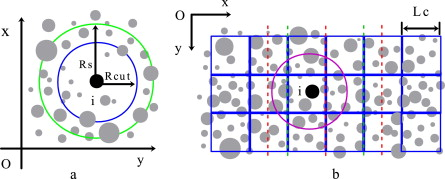

Para partículas mais distantes que $r_s$, somente após $n$ passos poderemos ter uma possível interação. 

A ideia é construir uma lista que leve em conta somente os vizinhos que estão no interior de uma esfera de raio $r_s$. 


In [ ]:
def lista_de_vizinhos(r,rs=2.8):
        """Construindo uma lista de vizinhos de Verlet dentro de uma região rcell"""
        NL = [[] for _ in range(r.shape[0])]
        for i in range(r.shape[0]):
            for j in range(i+1,r.shape[0]):
                rij = r[i]-r[j]
                # aplicando pbc
                rij[0] -= np.rint(rij[0]/L)*L # em x
                rij[1] -= np.rint(rij[1]/L)*L # em y
                rij[2] -= np.rint(rij[2]/L)*L # em z
                # calcula distancia entre duas particulas
                rij_norm = np.linalg.norm(rij)
                # Vamos considerar somente interação dentro do raio de corte
                if rij_norm < rs:
                    NL[i].append(j)
        return NL

Refazendo algumas funções para levar em conta a lista de vizinhos

In [ ]:
def interacao_lj(r,NL,L,epsilon=1.0,sigma=1.0,rcut=2.5):
    U = 0.0
    a = np.zeros_like(r)
    for i in range(r.shape[0]):
        for j in NL[i]:
            rij = r[i]-r[j]
            # aplicando pbc
            rij[0] -= np.rint(rij[0]/L)*L # em x
            rij[1] -= np.rint(rij[1]/L)*L # em y
            rij[2] -= np.rint(rij[2]/L)*L # em z
            # calcula distancia entre duas particulas
            rij_norm = np.linalg.norm(rij)
            if rij_norm < rcut:
                # calcula energia interna
                U += ulj(rij_norm,epsilon,sigma)
                # calcula a derivada do potencial
                dudr = duljdr(rij_norm,epsilon,sigma)
                # calcula aceleração na particula i
                a[i][0] += -dudr*rij[0]/rij_norm
                a[i][1] += -dudr*rij[1]/rij_norm
                a[i][2] += -dudr*rij[2]/rij_norm
                # calcula aceleração na particula j usando 3ª Lei de Newton
                a[j][0] += dudr*rij[0]/rij_norm
                a[j][1] += dudr*rij[1]/rij_norm
                a[j][2] += dudr*rij[2]/rij_norm
    return U, a

def integrador_verlet(r,v,a,NL,L,h = 0.001):
        # update das velocidades
        v[:] += 0.5*a*h
        # update das posições
        r[:] += h * v
        # condição de contorno periódica 
        r[:] = r % L
        # calcula nova aceleração 
        U, a = interacao_lj(r,NL,L,epsilon=1.0,sigma=1.0,rcut=2.5)
        # update das velocidades
        v[:] += 0.5*a*h
        # calcula energia cinetica
        K = 0.5*np.sum(v**2)
        return r, v, a, U, K

Fazendo 1000 integrações usando Lista de Vizinhos

In [ ]:
v = np.random.randn(Np,3)

Nsteps = 1000

print(f'iter{" ":7}U{" ":7}K{" ":7}E')
for i in range(Nsteps):
    if i % 20 == 0:  # para refazer a lista de vizinhos
        NL = lista_de_vizinhos(r)

    r[:], v[:], a[:], U, K  = integrador_verlet(r,v,a,NL,L)

    if i % 50 == 0:  # para printar a cada 50 passos
        print(f'{i:5d}\t {U:.3f}\t {K:.3f}\t {K+U:.3f}')

## Passo 3: Cálculo da Temperatura

Da termodinâmica sabemos que para um gás de partículas simples temos 

$$\frac{3}{2} N k_B T = \sum_{i=1}^N \frac{m_i v_i^2}{2} = K$$

ou seja, a energia cinética total das partículas é igual a energia térmica das partículas. Desta forma, podemos definir a temperatura como sendo 

$$ k_B T = \frac{2}{3} \frac{K}{N}$$

a energia cinética média das partículas. 

In [ ]:
v = np.random.randn(Np,3)

Nsteps = 1000

print(f'{"iter":^10} {"U":^10} {"K":^10} {"E":^10} {"kT":^10}')
for i in range(Nsteps):
    if i % 20 == 0:  # para refazer a lista de vizinhos
        NL = lista_de_vizinhos(r)

    r[:], v[:], a[:], U, K  = integrador_verlet(r,v,a,NL,L)

    kT = 2*K/(3*Np)

    if i % 50 == 0:  # para printar a cada 50 passos
        print(f'{i:5d}\t {U:.3f}\t {K:.3f}\t {K+U:.3f}\t {kT:.3f}')

## Passo 3: Cálculo da Pressão

Vimos que a energia potencial do sistema é dada por 

$$U = \frac{1}{2}\sum_{i=1}^N \sum_{j \neq i}^N u(\boldsymbol{r}_{ij})$$

Da termodinâmica, sabemos que 

$$P = \rho k_B T - \left(\frac{\partial U}{\partial V}\right)_{N,S}$$

Como a distância entre duas partículas $\boldsymbol{r}_{ij}$ pode ser escrita em termos de um comprimento característico da caixa de simulação $\ell$ tal que $\boldsymbol{r}_{ij} = \boldsymbol{s}_{ij} \ell$ e que $V = \ell^3$, podemos escrever que 

$$\left(\frac{\partial U}{\partial V}\right)_{N,S} = \frac{1}{2}\sum_{i=1}^N \sum_{j \neq i}^N \frac{\partial u(\boldsymbol{r}_{ij})}{\partial \boldsymbol{r}_{ij}} \cdot \frac{\partial \boldsymbol{r}_{ij}}{\partial V}$$

e usando que $\frac{\partial \boldsymbol{r}_{ij}}{\partial V} = \boldsymbol{r}_{ij}/(3V)$ chegamos a 

$$P = \rho k_B T + \frac{W}{3V}$$

$$W=  \frac{1}{2}\sum_{i=1}^N \sum_{j \neq i}^N \boldsymbol{f}_{ij} \cdot \boldsymbol{r}_{ij}$$

sendo $W$ o termo de virial que pode ser calculado pelo produto entre as forças e os deslocamentos. 

In [ ]:
def interacao_lj(r,NL,L,epsilon=1.0,sigma=1.0,rcut=2.5):
    U = 0.0
    W = 0.0
    a = np.zeros_like(r)
    for i in range(r.shape[0]):
        for j in NL[i]:
            rij = r[i]-r[j]
            # aplicando pbc
            rij[0] -= np.rint(rij[0]/L)*L # em x
            rij[1] -= np.rint(rij[1]/L)*L # em y
            rij[2] -= np.rint(rij[2]/L)*L # em z
            # calcula distancia entre duas particulas
            rij_norm = np.linalg.norm(rij)
            if rij_norm < rcut:
                # calcula energia interna
                U += ulj(rij_norm,epsilon,sigma)
                # calcula a derivada do potencial
                dudr = duljdr(rij_norm,epsilon,sigma)
                # calcula aceleração na particula i
                a[i][0] += -dudr*rij[0]/rij_norm
                a[i][1] += -dudr*rij[1]/rij_norm
                a[i][2] += -dudr*rij[2]/rij_norm
                # calcula aceleração na particula j usando 3ª Lei de Newton
                a[j][0] += dudr*rij[0]/rij_norm
                a[j][1] += dudr*rij[1]/rij_norm
                a[j][2] += dudr*rij[2]/rij_norm
                # calcula correção da pressao 
                W += dudr*rij_norm
    return U, W, a

def integrador_verlet(r,v,a,NL,L,h = 0.001):
        # update das velocidades
        v[:] += 0.5*a*h
        # update das posições
        r[:] += h * v
        # condição de contorno periódica 
        r[:] = r % L
        # calcula nova aceleração 
        U, W, a = interacao_lj(r,NL,L,epsilon=1.0,sigma=1.0,rcut=2.5)
        # update das velocidades
        v[:] += 0.5*a*h
        # calcula energia cinetica
        K = 0.5*np.sum(v**2)
        return r, v, a, U, K, W

In [ ]:
v = np.random.randn(Np,3)

Nsteps = 1000

print(f'{"iter":^10} {"U":^10} {"K":^10} {"E":^10} {"kT":^10} {"P":^10}')
for i in range(Nsteps):
    if i % 20 == 0:  # para refazer a lista de vizinhos
        NL = lista_de_vizinhos(r)

    r[:], v[:], a[:], U, K, W  = integrador_verlet(r,v,a,NL,L)

    kT = 2*K/(3*Np)
    P = (Np*kT + W/3)/(L**3)

    if i % 50 == 0:  # para printar a cada 50 passos
        print(f'{i:5d}\t {U:.3f}\t {K:.3f}\t {K+U:.3f}\t {kT:.3f}\t {P:.3f}')

Distribuição de velocidades

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(10,3))

vx = np.arange(-5,5,0.1)
fvx = np.exp(-vx**2/(2))/np.sqrt(2*np.pi)

n, bins = np.histogram(v[:,0],bins=15,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[0].scatter(meanbins,n,marker='o',color='C0')
axs[0].plot(vx,fvx,'k')
axs[0].set_xlabel(r'$v_x$')

n, bins = np.histogram(v[:,1],bins=15,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[1].scatter(meanbins,n,marker='o',color='C1')
axs[1].plot(vx,fvx,'k')
axs[1].set_xlabel(r'$v_y$')

n, bins = np.histogram(v[:,2],bins=15,range=(vx.min(),vx.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
axs[2].scatter(meanbins,n,marker='o',color='C2')
axs[2].plot(vx,fvx,'k')
axs[2].set_xlabel(r'$v_z$')

axs[0].set_ylim(0,0.5)

## Grand Finale: Criando uma Classe `LJsystem`

In [ ]:
class LJsystem():
    # Função que cria a classe
    def __init__(self,N_atoms, m = 1.0, epsilon = 1.0, sigma = 1.0, rcut = 2.5):
        self.N_atoms = N_atoms

        # parametros dos atomos
        self.m = m
        self.sigma = sigma
        self.epsilon = epsilon

        # parametro de cutoff da interação de LJ
        self.rcut = rcut

        # Arrays de posições
        self.r = np.zeros((self.N_atoms,3))

        # Arrays de velocidade
        self.v = np.zeros((self.N_atoms,3))       

        # Arrays de aceleração
        self.a = np.zeros((self.N_atoms,3))

    def Set_Density(self,rho):
        self.rho = rho
        # calcular o tamanho da caixa necessária 
        self.Vol = self.N_atoms/self.rho
        self.L = np.power(self.Vol,1/3.0)

    def Initialize_Positions(self):
        # Número de pontos em x e y
        Nx = Ny = Nz = int(np.ceil(np.power(self.N_atoms/4,1/3.0)))

        # Espaçamento entre os átomos
        dx = self.L/Nx
        dy = self.L/Ny
        dz = self.L/Nz

        # Posições possíveis em x e y numa rede cristalina tipo FCC
        id = 0
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    if (id < self.N_atoms):
                        self.r[id][0] = i*dx
                        self.r[id][1] = j*dy
                        self.r[id][2] = k*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.r[id][0] = i*dx
                        self.r[id][1] = (j+0.5)*dy
                        self.r[id][2] = (k+0.5)*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.r[id][0] = (i+0.5)*dx
                        self.r[id][1] = j*dy
                        self.r[id][2] = (k+0.5)*dz
                        id +=1

                    if (id < self.N_atoms):
                        self.r[id][0] = (i+0.5)*dx
                        self.r[id][1] = (j+0.5)*dy
                        self.r[id][2] = k*dz
                        id +=1
                        
    def Initialize_Velocities(self,kT= 1.0):
        self.kT = kT

        # sorteia uma distribuição normal com devio padrão proporcional a temperatura
        self.v = np.sqrt(self.kT/self.m)*np.random.randn(self.N_atoms,3)

        # retira qualquer movimento total
        self.v[:] -= self.v.mean(axis=0)

    def Get_KineticEnergy(self):
        self.K = 0.5*self.m*np.sum(self.v**2)
        return self.K
    
    def Build_NeighborList(self,rs=2.8):
        """Construindo uma lista de vizinhos de Verlet dentro de uma região rcell"""
        self.rs = rs
        self.NL = [[] for _ in range(self.N_atoms)]
        for i in range(self.N_atoms):
            for j in range(i+1, self.N_atoms):
                # calcula distancia entre duas particulas
                rij = self.r[i]-self.r[j]
                # aplicando pbc
                rij[:] -= np.rint(rij/self.L)*self.L 
                # calcula distancia entre duas particulas
                rij_norm = np.linalg.norm(rij)
                # Vamos considerar somente interação dentro do raio de corte
                if rij_norm < self.rs:
                    self.NL[i].append(j)

    def Calculate_Interactions(self):
        self.a[:] = 0.0
        self.U = 0.0
        self.W = 0.0
        for i in range(self.N_atoms):
            for j in self.NL[i]: # <-------- troca os limites 
                # calcula distancia entre duas particulas
                rij = self.r[i]-self.r[j]
                # aplicando pbc
                rij[:] -= np.rint(rij/self.L)*self.L 
                # calcula distancia entre duas particulas
                rij_norm = np.linalg.norm(rij)
                if rij_norm < self.rcut:
                    # calcula energia interna
                    self.U += ulj(rij_norm,self.epsilon,self.sigma)
                    # calcula a derivada do potencial
                    dudr = duljdr(rij_norm,self.epsilon,self.sigma)
                    # calcula aceleração na particula i
                    self.a[i] += -dudr*rij/rij_norm
                    # calcula aceleração na particula j usando 3ª Lei de Newton
                    self.a[j] += dudr*rij/rij_norm
                    # calcula correção da pressao 
                    self.W += dudr*rij_norm

    def Get_PotentialEnergy(self):
        return self.U
    
    def Get_Energies(self):
        self.Get_KineticEnergy()
        kT = 2*self.K/(3*self.N_atoms)
        return self.K, self.U, kT
    
    def Calculate_Pressure(self):
        kT = 2*self.K/(3*self.N_atoms)
        return self.rho*kT + self.W/(3*self.Vol)
    
    def Set_TimeStep(self,h):
        self.h = h
    
    def Calculate_TimeStep(self):
        # update das velocidades
        self.v[:] += 0.5*self.a*self.h
        # update das posições
        self.r[:] += self.h * self.v
        # condição de contorno periódica 
        self.r[:] = self.r % self.L
        # calcula nova aceleração 
        self.Calculate_Interactions()
        # update das velocidades
        self.v[:] += 0.5*self.a*self.h

    def RunSimulation(self,N_steps,Step_to_print=50,Step_tolist_update=20):
        self.N_steps = N_steps
        self.Step_to_print = Step_to_print # steps to print output
        self.Step_tolist_update = Step_tolist_update

        self.Build_NeighborList()
        self.Calculate_Interactions()

        print('iter\t K\t U\t E\t T\t P')

        t = []
        K = []
        U = []
        E = []
        T = []
        P = []

        Ktemp, Utemp, Ttemp = self.Get_Energies()
        Ptemp = self.Calculate_Pressure()
        Kmed = Ktemp
        Umed = Utemp
        Emed = Ktemp+Utemp
        Tmed = Ttemp
        Pmed = Ptemp

        for i in range(1,self.N_steps+1):

            if i % self.Step_tolist_update == 0:
                self.Build_NeighborList()

            self.Calculate_TimeStep()

            Ktemp, Utemp, Ttemp = self.Get_Energies()
            Ptemp = self.Calculate_Pressure()
            Kmed += Ktemp
            Umed += Utemp
            Tmed += Ttemp
            Emed += Ktemp+Utemp
            Pmed += Ptemp

            if i % self.Step_to_print == 0:
                Kmed /= Step_to_print
                Umed /= Step_to_print
                Emed /= Step_to_print
                Tmed /= Step_to_print
                Pmed /= Step_to_print
                t.append(i)
                K.append(Kmed)
                U.append(Umed)
                E.append(Emed)
                T.append(Tmed)
                P.append(Pmed)
                print(f'{i:5d}\t {Kmed:.4f}\t {Umed:.4f}\t {Emed:.4f}\t {Tmed:.4f}\t {Pmed:.4f}')
                Kmed = 0.0
                Umed = 0.0
                Emed = 0.0
                Tmed = 0.0
                Pmed = 0.0

        return np.array(t), np.array(K), np.array(U), np.array(E), np.array(T), np.array(P)

In [ ]:
rho = 0.55
kT = 1.38

N_atoms=256

lj = LJsystem(N_atoms=N_atoms,m=1.0,epsilon=1.0,sigma=1.0)
lj.Set_Density(rho=rho)
lj.Initialize_Positions()
lj.Initialize_Velocities(kT=kT)
lj.Set_TimeStep(h=0.003)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(lj.r[:,0],lj.r[:,1],'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj.r[:,0],lj.r[:,1],lj.v[:,0],lj.v[:,1],color='C0') # vetor de velocidade

plt.xlim(0,lj.L)
plt.ylim(0,lj.L)

plt.xlabel('x')
plt.ylabel('y')

In [ ]:
t, K, U, E, T, P = lj.RunSimulation(N_steps=2000,Step_to_print=50)

Gráfico das posições finais das partículas

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(lj.r[:,0],lj.r[:,1],'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj.r[:,0],lj.r[:,1],lj.v[:,0],lj.v[:,1],color='C0') # vetor de velocidade

plt.xlim(0,lj.L)
plt.ylim(0,lj.L)

plt.xlabel('x')
plt.ylabel('y')

Gráfico da evolução de $U$ e $T$ como função dos passos de iteração

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(t,E/lj.N_atoms,'k',label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel(r'$E/(N\epsilon)$')

axs[1].plot(t,U/lj.N_atoms,label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel(r'$U/(N\epsilon)$')

axs[2].plot(t,T,color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_ylabel(r'$k_B T/\epsilon$')

axs[3].plot(t,P,color='C2',label='P')
axs[3].legend(loc='best')
axs[3].set_xlabel(r'$t/\tau$')
axs[3].set_ylabel(r'$P \sigma^3/\epsilon$')

## Calculando Médias e Desvios Padrão

In [ ]:
teq = 150
subsett = t[t>teq]
subsetT = T[t>teq]
subsetP = P[t>teq]
subsetU = U[t>teq]/lj.N_atoms

Energia Interna

In [ ]:
Umean = subsetU.mean()

sigmaU = subsetU.std()

print(rf"A energia interna do sistema é {Umean:.2f}+-{sigmaU:.2f} por partícula")

In [ ]:
plt.xlabel(r'$U/\epsilon$')
plt.ylabel('Densidade de Probabilidade')

uarray = np.arange(-3.6,-3.2,0.001)
plt.plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

n, bins = np.histogram(subsetU,bins=15,range=(uarray.min(),uarray.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
plt.scatter(meanbins,n,marker='o',color='C0')

Temperatura

In [ ]:
Tmean = subsetT.mean()
sigmaT = subsetT.std()

print(rf"A temperatura do sistema é {Tmean:.2f}+-{sigmaT:.2f}")

In [ ]:
plt.xlabel(r'$k_B T/\epsilon$')
plt.ylabel('Densidade de Probabilidade')

Tarray = np.arange(1.2,1.5,0.001)
plt.plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

n, bins = np.histogram(subsetT,bins=15,range=(Tarray.min(),Tarray.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
plt.scatter(meanbins,n,marker='o',color='C3')

Pressão

In [ ]:
Pmean = subsetP.mean()
sigmaP = subsetP.std()

print(rf"A pressão do sistema é {Pmean:.2f}+-{sigmaP:.2f}")

In [ ]:
plt.xlabel(r'$P \sigma^3/\epsilon$')
plt.ylabel('Densidade de Probabilidade')

Parray = np.arange(0.0,1.6,0.001)
plt.plot(Parray,np.sqrt(1/(2*np.pi*sigmaP**2))*np.exp(-0.5*(Parray-Pmean)**2/sigmaP**2),color='k')

n, bins = np.histogram(subsetP,bins=15,range=(Parray.min(),Parray.max()),density=True)
meanbins = 0.5*(bins[1:]+bins[:-1])
plt.scatter(meanbins,n,marker='o',color='C2')

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Refaça a simulação usando 864 partículas. Compare os resultados.